# 作业要求

1. 用Logistic Regression对以下数据集进行分类，以分类精度Accuracy作为评估指标，即预测正确的样本数与总样本数之比
2. 按机器学习的流程执行任务，画出必要的图（用带L2正则化的梯度下降算法优化）
3. 通过交叉验证确定最优特征数（最高幂次和L2正则化系数）
4. 画出决策边界

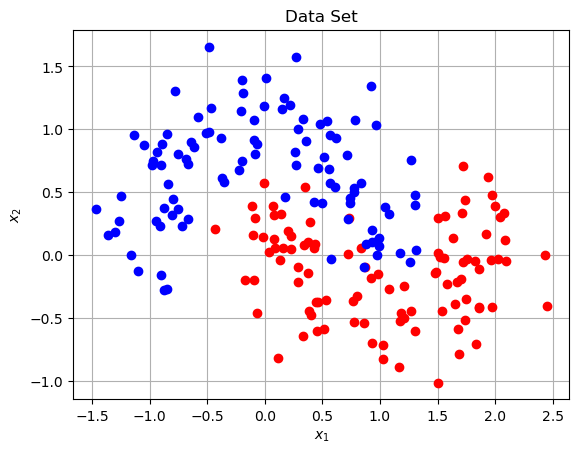

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, Y = make_moons(n_samples=200,noise=0.25,random_state=43)
m = X.shape[0]

plt.plot(X[np.where(Y==1), 0], X[(np.where(Y==1)), 1], 'ro')
plt.plot(X[np.where(Y==0), 0], X[(np.where(Y==0)), 1], 'bo')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data Set")
plt.grid(True)

# 用Logistic Regression分类

## Logistic回归原理

$X$是元素为$(x_1,x_2)$构成的向量组，我们可以用$X$预测$Y$，即
$$
h_{\theta}(x^i)=\theta_0+\theta_1x_1^i+\cdots+\theta_nx_n^i
$$
为了根据预测出的$\hat{y}$分类，用连续可微函数$g(\cdot)$将$y$缩放成区间$(0,1)$的数。
$$
h_{\theta}(x)=g(\theta_0+\theta_1x_1+\cdots+\theta_nx_n)
$$
$$
g(z)=\frac{1}{1+e^{-z}}
$$
其中$z=\theta_0+\theta_1x_1+\cdots+\theta_nx_n$

## 代码实现

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, log_loss

### 数据预处理

第一步包括特征选择（因为是玩具变量故不用特征规范化）

In [4]:
# 生成数据集
X, y = make_moons(n_samples=200, noise=0.25, random_state=43)

### 数据集划分
第二步包括
- 训练集：训练权重
- 测试集：检验推广能力（调超参数）

之后用`cross_val_score`包进行K-fold cv（全称k-fold cross validation），保证良好的稳健性，`scoreing`选分类精度`accuracy`

### 确定模型

第三步已经确定为Logistic模型，这里尝试用一个类(class)来打包实现Logistic回归

`initiate`初始化logistic回归梯度下降的学习率$\alpha$，迭代次数$n$，L2正则化系数$\lambda$

`fit`正式进行梯度下降迭代，`h`表示由算法迭代的系数值$\Theta$推出的预测值 $\Rightarrow \displaystyle \frac{1}{1+e^{-X\Theta}}$，相当于上一章的$X\Theta$。同样的，现在的error是$\displaystyle \frac{1}{1+e^{-X\Theta}}-y$，instead of $X\Theta-y$

Logistic回归的损失函数变成交叉熵，或Logistic loss
$$
J(\Theta)=\frac{1}{2m}\sum_{i=1}^m(h(x^i)-y^i)^2
$$

加L2正则化的梯度下降公式为

$$
\Theta = \Theta - \frac{\alpha}{m}\left[X^T\left(\frac{1}{1+e^{-X\Theta}}-y\right)+\lambda \Theta \right]
$$

`predict`用于对新输入的$X$做预测。其中`predictions`那段可以有更简洁更fancy的写法：

```python
return [1 if p >= 0.5 else 0 for p in probability]
```

In [8]:
class LogisticReg:
    def __init__(self, learning_rate=0.01, n_iteration=1000, l2_reg=0.01):
        self.learning_rate = learning_rate
        self.n_iteration = n_iteration
        self.l2_reg = l2_reg

    def sigmoid(self, z):
        exp_term = np.exp(-z)
        return 1 / (1 + np.clip(exp_term, a_min=1e-5, a_max=None))
    
    def fit(self, X, y):
        m,n = X.shape
        self.theta = np.random.rand(n)
        for i in range(self.n_iteration):
            z = np.dot(X,self.theta)
            h = self.sigmoid(z)
            gradient = (1/m) * np.dot(X.T,(h-y)) + (self.l2_reg / m) * self.theta
            self.theta -= self.learning_rate * gradient

    def predict(self, X):
        z = np.dot(X, self.theta)
        probability = self.sigmoid(z)
        predictions = []
        for p in probability:
            if p >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    
    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_iteration': self.n_iteration,
            'l2_reg': self.l2_reg
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


### 训练，调参

第四步是最关键的，训练和调超参数。该模型中有 $学习率\alpha,迭代次数n_i,正则化系数\lambda,最高幂次n$ 三个超参数。

前两个我们并不太关心，根据过去的经验直接取$\alpha=0.01,n_i=1000$就好。所以现在就只剩：$最高幂次n,正则化系数\lambda$

1. 最高次幂$n$

/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(-z)
/var/folders/_3/gr2mmh2j7ddg7w53_vswt5qh0000gn/T/ipykernel_35985/695039305.py:8: RuntimeWarning: overflow 

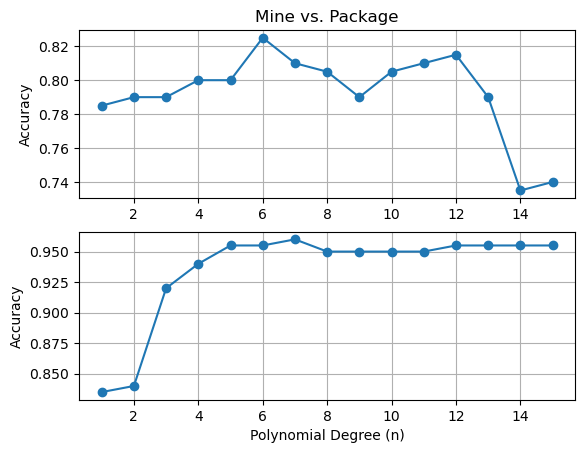

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

n_values = range(1, 16) 
accuracy_scores_mine = []
accuracy_scores_package = []

for n in n_values:
    poly_features = PolynomialFeatures(degree=n)
    X_train_poly = poly_features.fit_transform(X)
    clf = LogisticReg()
    
    scores = cross_val_score(clf, X_train_poly, y, cv=5, scoring="accuracy")
    mean_score = np.mean(scores)
    accuracy_scores_mine.append(mean_score)

for n in n_values:
    poly_features = PolynomialFeatures(degree=n)
    X_train_poly = poly_features.fit_transform(X)
    clf = LogisticRegression()
    
    scores = cross_val_score(clf, X_train_poly, y, cv=5, scoring="accuracy")
    mean_score = np.mean(scores)
    accuracy_scores_package.append(mean_score)


plt.subplot(2,1,1)
plt.plot(n_values, accuracy_scores_mine, marker='o')
plt.title("Mine vs. Package")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(n_values, accuracy_scores_package, marker='o')
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

暂且用`LogisticRegression`的包来找哪个$n$最好（训练集和测试集相交的地方）

/Users/zdf/opt/anaconda3/envs/manim_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/zdf/opt/anaconda3/envs/manim_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/zdf/opt/anaconda3/envs/manim_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/zdf/opt/anaconda3/envs/manim_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, s

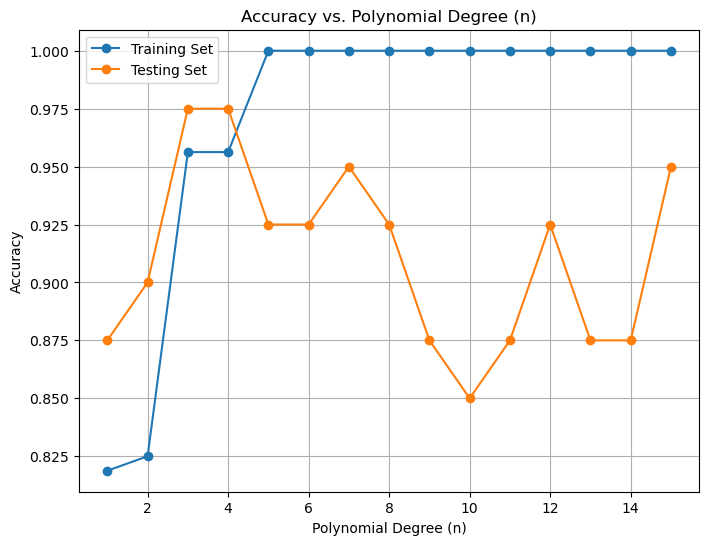

In [21]:
X, y = make_moons(n_samples=200, noise=0.25, random_state=43)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

n_values = range(1, 16)  # Range of polynomial degrees to test
train_accuracy_scores = []
test_accuracy_scores = []

for n in n_values:
    poly_features = PolynomialFeatures(degree=n)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # Train Logistic Regression model without regularization
    clf = LogisticRegression(penalty='none', max_iter=10000)  # No L2 regularization
    clf.fit(X_train_poly, y_train)
    
    # Evaluate accuracy on the training set
    train_accuracy = clf.score(X_train_poly, y_train)
    train_accuracy_scores.append(train_accuracy)
    
    # Evaluate accuracy on the testing set
    test_accuracy = clf.score(X_test_poly, y_test)
    test_accuracy_scores.append(test_accuracy)

# Plot both lines on the same graph
plt.figure(figsize=(8, 6))
plt.plot(n_values, train_accuracy_scores, marker='o', label="Training Set")
plt.plot(n_values, test_accuracy_scores, marker='o', label="Testing Set")
plt.title("Accuracy vs. Polynomial Degree (n)")
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


当$n<4$时测试集比训练集精度高是因为瞎猜的，$n>5$时测试集精度明显低于训练集是因为过拟合，所以最好的最高次幂应为$n=4$

2. 正则化系数$\lambda$

我的思路是对于每个$\lambda$分别用训练集和测试集来检验，找到对两个数据集精度都比较高的$\lambda$，大概是在$10^{-3}\sim 10^{-1}$左右

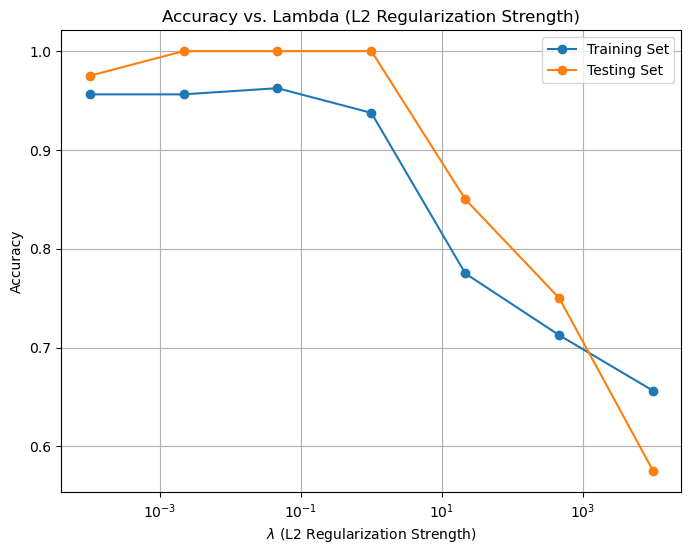

In [26]:
degree = 4
lambdas = np.logspace(-4, 4, 7)

train_accuracy_scores = []
test_accuracy_scores = []

for lambda_ in lambdas:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    clf = LogisticRegression(penalty='l2', C=1.0 / lambda_, max_iter=10000)
    clf.fit(X_train_poly, y_train)

    train_accuracy = clf.score(X_train_poly, y_train)
    train_accuracy_scores.append(train_accuracy)

    test_accuracy = clf.score(X_test_poly, y_test)
    test_accuracy_scores.append(test_accuracy)

plt.figure(figsize=(8, 6))
plt.semilogx(lambdas, train_accuracy_scores, marker='o', label="Training Set")
plt.semilogx(lambdas, test_accuracy_scores, marker='o', label="Testing Set")
plt.title("Accuracy vs. Lambda (L2 Regularization Strength)")
plt.xlabel(r"$\lambda$ (L2 Regularization Strength)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# 交叉验证确定最优特征数

生成数据集，数据集分割同上

不同的最高幂次：degrees是一个包含1、2和4的列表，然而这里主要关注degree=4的情况

绘制不同特征数对应的图：使用matplotlib绘制不同最高幂次下的图。在每个子图中，

1. 使用PolynomialFeatures将特征转换为指定最高幂次的多项式特征
2. 创建Logistic Regression 模型，使用L2正则化，求解器选择'lbfgs'
3. 绘制决策边界，使用模型对特征空间的网格进行预测，并绘制决策区域
4. 绘制测试集数据点，分为两个类别，用不同的颜色标识

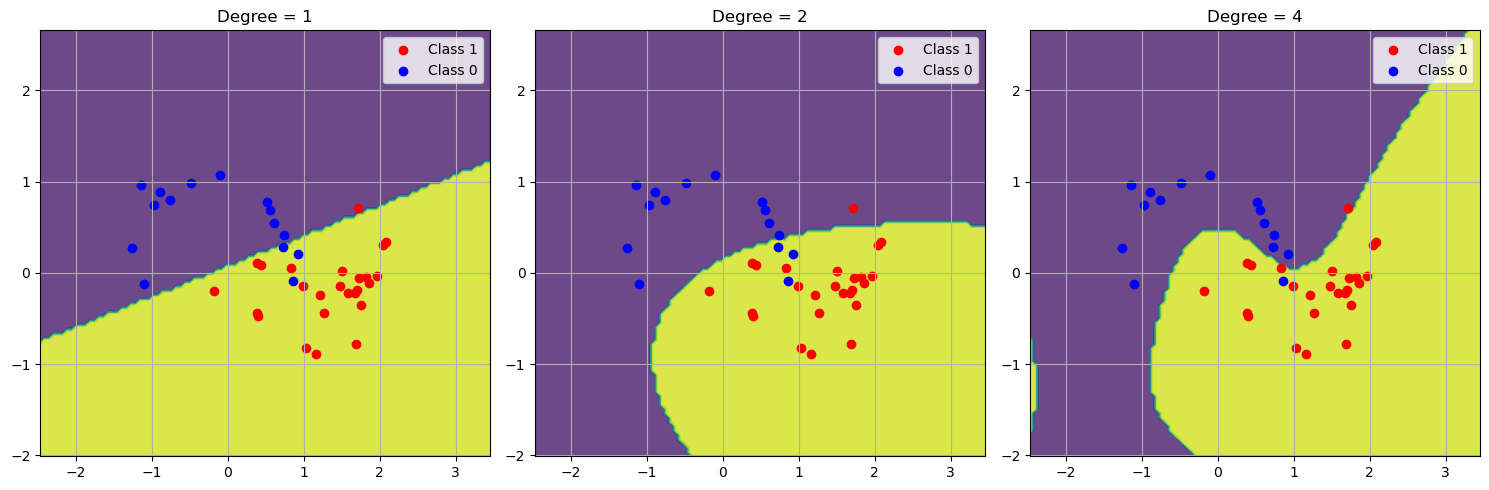

In [28]:
# 生成数据集
X, Y = make_moons(n_samples=200, noise=0.25, random_state=43)

# 将数据集分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 不同的最高幂次
degrees = [1, 2, 4]

# 绘制不同特征数对应的图
plt.figure(figsize=(15, 5))
for i, degree in enumerate(degrees):
    plt.subplot(1, len(degrees), i + 1)

    # 使用多项式特征
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    
    # 创建Logistic Regression 模型
    model = LogisticRegression(penalty='l2', solver='lbfgs')
    model.fit(X_train_poly, Y_train)

    # 绘制决策边界
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
    Z = model.predict(poly.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_test[np.where(Y_test == 1), 0], X_test[np.where(Y_test == 1), 1], c='red', marker='o', label='Class 1')
    plt.scatter(X_test[np.where(Y_test == 0), 0], X_test[np.where(Y_test == 0), 1], c='blue', marker='o', label='Class 0')
    plt.title(f'Degree = {degree}')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()
